# Axial vibration of a 1D bar

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geoelements/learn-mpm/blob/main/book/axial-vibration1d.ipynb)
[![Try on DesignSafe](https://raw.githubusercontent.com/geoelements/LearnMPM/main/DesignSafe-Badge.svg)](https://jupyter.designsafe-ci.org/hub/user-redirect/notebooks/CommunityData/Use%20Case%20Products/MPM/LearnMPM/axial-vibration1d.ipynb)

![Axial vibration of a continuum bar](img/axial-vibration-continuum-bar.jpg)
> Schematic of uniform bar undergoing longitudinal motion

## Analytical solution

In [3]:
import numpy as np

def axial_vibration_bar1d(L, E, rho, duration, dt, v0, x):

    # Frequency of system mode 1
    w1 = np.pi / (2 * L) * np.sqrt(E/rho)
    b1 = np.pi / (2 * L)

    # position and velocity in time
    tt, vt, xt = [], [], []

    nsteps = int(duration/dt)
    t = 0
    for _ in range(nsteps):
        vt.append(v0 * np.cos(w1 * t) * np.sin(b1 * x))
        xt.append(v0 / w1 * np.sin(w1 * t) * np.sin(b1 * x))
        tt.append(t)

        t += dt
    
    return tt, vt, xt

Let's now plot the analytical solution of a vibrating bar at the end of the bar $x = 1$

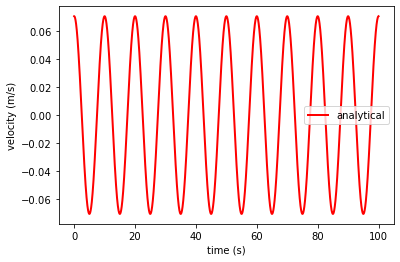

In [4]:
import matplotlib.pyplot as plt

# Properties
E = 100
L = 25

# analytical solution at the end of the bar
ta, va, xa = axial_vibration_bar1d(L = L, E = E, rho = 1, duration = 100, dt = 0.01, v0 = 0.1, x = 12.5)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

## MPM implementation

The grid consists of 13 two-noded line elements (14 grid nodes) and 13 material points placed at the center of the elements are used. We study the axial vibration of a continuum bar with Young’s modulus E = 100 and the bar length L = 25. The time increment is chosen as $\Delta t = 0.1 \Delta x / c$ where $\Delta x$ denotes the nodal spacing. The initial velocity is given by: $v (x, 0) = v_0 \sin (\beta_1 x)$, where $v_0 = 0.1$.

![MPM 1D mesh](img/mpm1d-mesh.png)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# mass tolerance
tol = 1e-12

# Domain
L = 25

# Material properties
E = 100
rho = 1

# Computational grid

nelements = 13 # number of elements
dx = L / nelements # element length

# Create equally spaced nodes
x_n = np.linspace(0, L, nelements+1)
nnodes = len(x_n)

# Set-up a 2D array of elements with node ids
elements = np.zeros((nelements, 2), dtype = int)
for nid in range(nelements):
    elements[nid, :] = np.array([nid, nid+1])

# Loading conditions
v0 = 0.1             # initial velocity
c  = np.sqrt(E/rho)  # speed of sound
b1 = np.pi / (2 * L) # beta1
w1 = b1 * c          # omega1

# Create material points at the center of each element
nparticles = nelements  # number of particles
# Id of the particle in the central element
pmid = int(np.floor((nparticles/2)))

# Material point properties
x_p      = np.zeros(nparticles)       # positions
vol_p    = np.ones(nparticles) * dx   # volume
mass_p   = vol_p * rho                # mass
stress_p = np.zeros(nparticles)       # stress
vel_p    = np.zeros(nparticles)       # velocity
vol0_p   = vol_p                      # initial volume

for i in range(nelements):
    # Create particle at the center
    x_p[i] = 0.5 * (x_n[i] + x_n[i+1])
    # set initial velocities
    vel_p[i] = v0 * np.sin(b1 * x_p[i])

# Time steps and duration
duration = 100
dt_crit = dx / c
dt = 0.1 * dt_crit
t = 0
nsteps = int(duration / dt)

tt, vt, xt = [], [], []

for step in range(nsteps):
    # reset nodal values
    mass_n  = np.zeros(nnodes)  # mass
    mom_n   = np.zeros(nnodes)  # momentum
    fint_n = np.zeros(nnodes)  # internal force

    # iterate through each element
    for id in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[id]
        
        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[id] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[id] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # map particle mass and momentum to nodes
        mass_n[nid1] += N1 * mass_p[id]
        mass_n[nid2] += N2 * mass_p[id]
        mom_n[nid1]  += N1 * mass_p[id] * vel_p[id]
        mom_n[nid2]  += N2 * mass_p[id] * vel_p[id]

        # compute nodal internal force
        fint_n[nid1] -= vol_p[id] * stress_p[id] * dN1
        fint_n[nid2] -= vol_p[id] * stress_p[id] * dN2

    # apply boundary conditions
    mom_n[0]  = 0  # Nodal velocity v = 0 in m * v at node 0.
    fint_n[0] = 0  # Nodal force f = m * a, where a = 0 at node 0.

    # update nodal momentum
    for nid in range(nnodes):
        mom_n[nid] += fint_n[nid] * dt

    # update particle velocity position and stress
    # iterate through each element
    for id in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[id]
        
        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[id] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[id] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # compute particle velocity
        if (mass_n[nid1]) > tol:
            vel_p[id] += dt * N1 * fint_n[nid1] / mass_n[nid1]
        if (mass_n[nid2]) > tol:
            vel_p[id] += dt * N2 * fint_n[nid2] / mass_n[nid2]
        
        # update particle position based on nodal momentum
        x_p[id] += dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2])

        # nodal velocity
        nv1 = mom_n[nid1]/mass_n[nid1]
        nv2 = mom_n[nid2]/mass_n[nid2]

        # Apply boundary condition
        # Rendundant, since momentum and forces are already set to zero
        # if (nid1 == 0): nv1 = 0

        # rate of strain increment
        grad_v = dN1 * nv1 + dN2 * nv2
        # particle dstrain
        dstrain = grad_v * dt
        # particle volume
        vol_p[id] *= (1 + dstrain)        
        # update stress using linear elastic model
        stress_p[id] += E * dstrain

    # update plot params
    tt.append(t)
    vt.append(vel_p[pmid])
    xt.append(x_p[pmid])

    t = t + dt

### Plot results

> Velocity

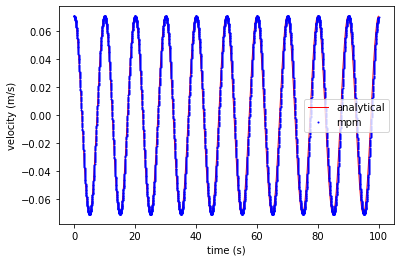

In [6]:
plt.plot(ta, va, 'r', linewidth=1,label='analytical')
plt.plot(tt, vt, 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

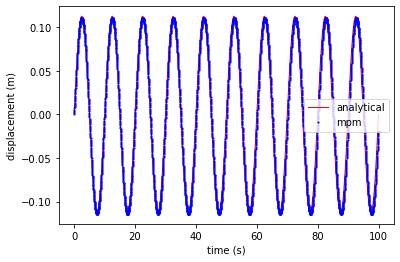

In [7]:
plt.plot(ta, xa, 'r', linewidth=1,label='analytical')
plt.plot(tt, xt - xt[0], 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.legend()
plt.show()

## Extending MPM to support multiple material points per element

The code we have written is specific for a two-noded element with a single material point at the center of the element. The first step is to implement multiple material points in an element. Let's start with particle generation:

```python
# Material point properties
x_p      = np.zeros(nparticles)       # positions
vol_p    = np.ones(nparticles) * dx   # volume
mass_p   = vol_p * rho                # mass
stress_p = np.zeros(nparticles)       # stress
vel_p    = np.zeros(nparticles)       # velocity
vol0_p   = vol_p                      # initial volume

# Generate material points in cell
for i in range(nelements):
    # Create particle at the center
    x_p[i] = 0.5 * (x_n[i] + x_n[i+1])
    # set initial velocities
    vel_p[i] = v0 * np.sin(b1 * x_p[i])
```

We are placing the particles at the center of the element, so the volume and mass of a particle is the volume and mass of the element. Let's create a new variable called `ppc` (particles per cell) to support multiple material points (particles) per cell.

In [8]:
# Material point properties
# Unchanged definitions
x_p      = np.zeros(nparticles)            # positions
stress_p = np.zeros(nparticles)            # stress
vel_p    = np.zeros(nparticles)            # velocity

# New/updated variables
ppc      = 1                               # particles / cell
vol_p    = np.ones(nparticles) * dx / ppc  # volume

# these variables haven't changed, they are updated based on vol
mass_p   = vol_p * rho                     # mass
vol0_p   = vol_p                           # initial volume

#### Generating material points in a cell

The current implementation generates a single material point per element.

In [9]:
x_p      = np.zeros(nparticles)            # positions
# Generate material points in cell
for i in range(nelements):
    # Create particle at the center
    x_p[i] = 0.5 * (x_n[i] + x_n[i+1])
    # set initial velocities
    vel_p[i] = v0 * np.sin(b1 * x_p[i])

> Let's plot the current mesh with a single material point per cell and see how it looks

In [10]:
# Function to plot mesh
import matplotlib.pyplot as plt
def plot_mesh(elements, x_n, x_p, fontsize=13):
    # plt.cla()
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    eid = 0
    for element in elements:
        n1, n2 = element
        n1x, n2x = x_n[n1], x_n[n2]
        plt.plot([n1x,n2x],[0,0],'--sk')
        dy = 0.005
        
        x=(n1x + n2x)/2
        plt.annotate("e%d"%eid, xy=(x,-1.5*dy),fontsize=fontsize)
        plt.annotate("n%d"%n1, xy=(n1x,dy),fontsize=fontsize)
        plt.annotate("n%d"%n2, xy=(n2x,dy),fontsize=fontsize)
        eid = eid + 1

    pid = 0    
    for x in x_p:
        plt.plot(x,0,'ob')
        plt.annotate("p%d"%pid, xy=(x, dy),fontsize=fontsize)
        pid = pid + 1
 
    n1 = elements[0][0]
    x = x_n[n1]
    y = -0.04
    plt.annotate("n = node\np = material point\ne = element", xy=(x,y),fontsize=fontsize)
    plt.xlabel(r"Node position, $x_I$")
    plt.title("Mesh and Material Points")
    plt.show()

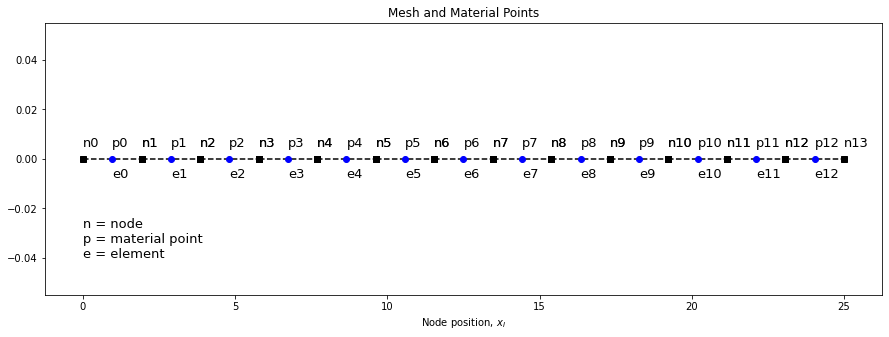

In [11]:
plot_mesh(elements, x_n, x_p)

#### Generating multiple material points per cell

Let's define a function that takes the number of particles per cell as an argument and return an array of positions.

In [12]:
def generate_particles(ppc, elements, x_n):
    """
    Generate particles in mesh

    Arguments:
    ppc: int
        number of particles per cell

    elements: List
        node ids of each element
    
    x_n: List
        nodal coordinates
    
    Returns:
    x_p: List
        particle coordinates
    el_pids: List
        List of particle ids for each cell
    """
    # ppc = number of particles per cell
    # total number of particles
    nparticles = nelements * ppc
    # positions
    x_p  = np.zeros(nparticles)
    # particle id
    pid = 0
    eid = 0

    # Create a map of particle ids to each element
    mpoints = []
    # iterate through each element
    for element in elements:
        # get nodal ids
        n1, n2 = element
        # get nodal coordinates
        n1x, n2x = x_n[n1], x_n[n2]
        # element length
        dx = abs(n2x - n1x)
        # create an empty list of particles for each cell
        particles = []
        # generate particles uniformly across the element
        for _ in range(ppc):
            # first particle
            if(len(particles)==0):
                x_p[pid] = n1x + dx/(2 * ppc)
            # last particle
            elif(len(particles)==(ppc - 1)):
                x_p[pid] = n2x - dx/(2 * ppc)
            # mid particles
            else:
                x_p[pid] = n1x + dx/(2 * ppc) + len(particles) * (dx/ppc)
            
            # Append to particles
            particles.append(pid)
            # particle id
            pid += 1
        
        # Add pids to each element
        mpoints.append(particles)
        # element id    
        eid += 1 

    return x_p, mpoints

> 1 PPC

Let us know generate a single material point per cell and plot to see if we get the same result.

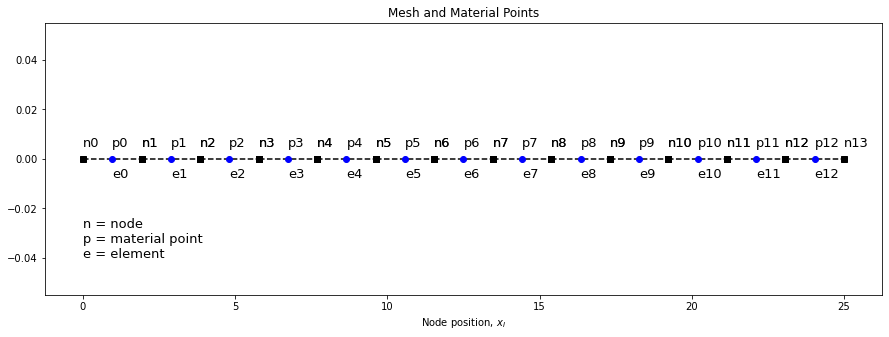

In [13]:
x_p, _ = generate_particles(ppc=1, elements=elements, x_n=x_n)
plot_mesh(elements, x_n, x_p)

> 2 PPC

Let us know generate two material point per cell.

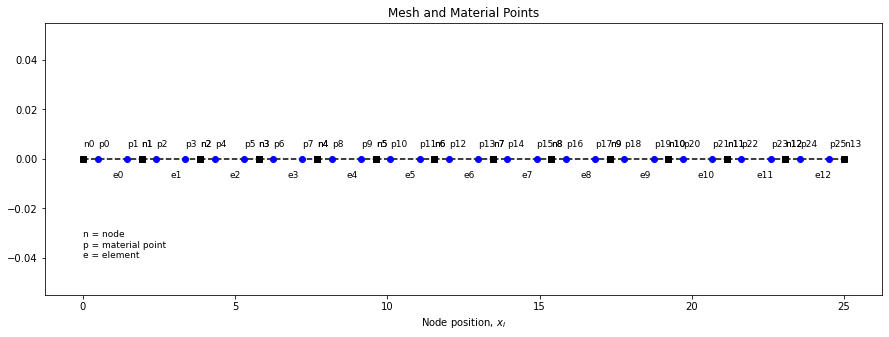

In [14]:
x_p, _ = generate_particles(ppc=2, elements=elements, x_n=x_n)
plot_mesh(elements, x_n, x_p, fontsize=9)

#### Iterate over particles

Now that we have the ability to generate multiple material points per cell, we should also change how we loop over particle to map particle properties to node. Instead of mapping a single material property to the node, we need to map all particles' properties in the element to the node.

```python
    # iterate through each element
    for eid in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[eid]

        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[id] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[id] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # map particle mass and momentum to nodes
        mass_n[nid1] += N1 * mass_p[id]
        mass_n[nid2] += N2 * mass_p[id]
        mom_n[nid1]  += N1 * mass_p[id] * vel_p[id]
        mom_n[nid2]  += N2 * mass_p[id] * vel_p[id]

        # compute nodal internal force
        fint_n[nid1] -= vol_p[id] * stress_p[id] * dN1
        fint_n[nid2] -= vol_p[id] * stress_p[id] * dN2
```

We need the associated particle ids for each element. We have the variable `mpoints` returned by `generate_particles()` function. The variable `mpoints` maps the particle ids to each element. Now we can iterate through all the particles in each element, instead of one particle per element.

```python
# iterate through each element
for eid in range(nelements):
    # get nodal ids
    nid1, nid2 = elements[eid]    
    # get particle ids associated with the element 
    mpts = mpoints[eid]
    # iterate through all particles in the element
    for pid in mpts:
        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[pid] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[pid] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # map particle mass and momentum to nodes
        mass_n[nid1] += N1 * mass_p[pid]
        mass_n[nid2] += N2 * mass_p[pid]
        mom_n[nid1]  += N1 * mass_p[pid] * vel_p[pid]
        mom_n[nid2]  += N2 * mass_p[pid] * vel_p[pid]

        # compute nodal internal force
        fint_n[nid1] -= vol_p[pid] * stress_p[pid] * dN1
        fint_n[nid2] -= vol_p[pid] * stress_p[pid] * dN2
```

Similarly, we will modify the mapping from node to particles.

### Multiple material points per cell

Full implementation to support multiple material points per cell. The following example shows how to perform the axial vibration in a 1D bar with 2 particles per cell.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# particles per cell
ppc      = 2                 

# mass tolerance
tol = 1e-12

# Domain
L = 25

# Material properties
E = 100
rho = 1

# Computational grid

nelements = 13 # number of elements
dx = L / nelements # element length

# Create equally spaced nodes
x_n = np.linspace(0, L, nelements+1)
nnodes = len(x_n)

# Set-up a 2D array of elements with node ids
elements = np.zeros((nelements, 2), dtype = int)
for nid in range(nelements):
    elements[nid, :] = np.array([nid, nid+1])

# Loading conditions
v0 = 0.1             # initial velocity
c  = np.sqrt(E/rho)  # speed of sound
b1 = np.pi / (2 * L) # beta1
w1 = b1 * c          # omega1

# Create material points 
nparticles = nelements * ppc  # number of particles
# Id of the particle in the central element
pmid = int(np.floor((nparticles/2)))

# Material point properties
x_p      = np.zeros(nparticles)       # positions
vol_p    = np.ones(nparticles)*dx/ppc # volume
mass_p   = vol_p * rho                # mass
stress_p = np.zeros(nparticles)       # stress
vel_p    = np.zeros(nparticles)       # velocity
vol0_p   = vol_p                      # initial volume
defg_p   = np.ones(nparticles)

# Generate particles
x_p, mpoints = generate_particles(ppc, elements, x_n)

for i in range(nparticles):
    # set initial velocities
    vel_p[i] = v0 * np.sin(b1 * x_p[i])

# Time steps and duration
duration = 100
dt_crit = dx / c
dt = 0.1 * dt_crit
t = 0
nsteps = int(duration / dt)

tt, vt, xt = [], [], []

for step in range(nsteps):
    # reset nodal values
    mass_n  = np.zeros(nnodes)  # mass
    mom_n   = np.zeros(nnodes)  # momentum
    fint_n = np.zeros(nnodes)  # internal force

    # iterate through each element
    for eid in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[eid]
        # get particle ids associated with the element 
        mpts = mpoints[eid]
        # iterate through all particles in the element
        for pid in mpts:
            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[pid] - x_n[nid1]) / dx
            N2 = 1 - abs(x_p[pid] - x_n[nid2]) / dx
            dN1 = -1/dx
            dN2 = 1/dx

            # map particle mass and momentum to nodes
            mass_n[nid1] += N1 * mass_p[pid]
            mass_n[nid2] += N2 * mass_p[pid]
            mom_n[nid1]  += N1 * mass_p[pid] * vel_p[pid]
            mom_n[nid2]  += N2 * mass_p[pid] * vel_p[pid]

            # compute nodal internal force
            fint_n[nid1] -= vol_p[pid] * stress_p[pid] * dN1
            fint_n[nid2] -= vol_p[pid] * stress_p[pid] * dN2

    # apply boundary conditions
    mom_n[0]  = 0  # Nodal velocity v = 0 in m * v at node 0.
    fint_n[0] = 0  # Nodal force f = m * a, where a = 0 at node 0.

    # update nodal momentum
    for nid in range(nnodes):
        mom_n[nid] += fint_n[nid] * dt

    # update particle velocity position and stress
    # iterate through each element
    for eid in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[eid]
        # get particle ids associated with the element 
        mpts = mpoints[eid]
        # iterate through all particles in the element
        for pid in mpts:
            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[pid] - x_n[nid1]) / dx
            N2 = 1 - abs(x_p[pid] - x_n[nid2]) / dx
            dN1 = -1/dx
            dN2 = 1/dx

            # compute particle velocity
            if (mass_n[nid1]) > tol:
                vel_p[pid] += dt * N1 * fint_n[nid1] / mass_n[nid1]
            if (mass_n[nid2]) > tol:
                vel_p[pid] += dt * N2 * fint_n[nid2] / mass_n[nid2]
            
            # update particle position based on nodal momentum
            x_p[pid] += dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2])

            # nodal velocity
            nv1 = mom_n[nid1]/mass_n[nid1]
            nv2 = mom_n[nid2]/mass_n[nid2]

            # Apply boundary condition
            # Rendundant, since momentum and forces are already set to zero
            # if (nid1 == 0): nv1 = 0

            # rate of strain increment
            grad_v = dN1 * nv1 + dN2 * nv2
            # particle dstrain
            dstrain = grad_v * dt
            # particle volume
            vol_p[pid] *= (1 + dstrain)        
            # update stress using linear elastic model
            stress_p[pid] += E * dstrain

    # update plot params
    tt.append(t)
    vt.append(vel_p[pmid])
    xt.append(x_p[pmid])

    t = t + dt

> Plot velocity at the center of the bar

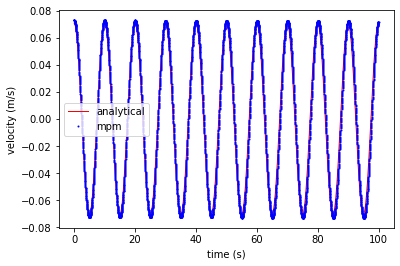

In [16]:
plt.plot(ta, va, 'r', linewidth=1,label='analytical')
plt.plot(tt, vt, 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

> Plot displacement at the center of the bar

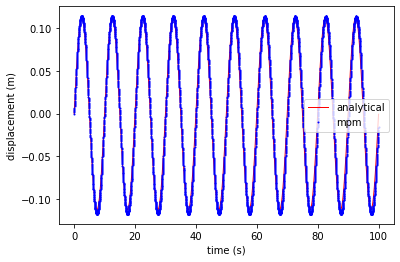

In [17]:
plt.plot(ta, xa, 'r', linewidth=1,label='analytical')
plt.plot(tt, xt-xt[0], 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.legend()
plt.show()